In [142]:
import json
import itertools
from typing import Tuple, List, Iterable

from scipy.io import loadmat
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, JpegImagePlugin, ImageFont
import numpy as np
from matplotlib.pyplot import imshow
from matplotlib import cm


In [2]:
train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')

In [3]:
first_image = train['X'][:, :, :, 0]
second_image = train['X'][:, :, :, 1]
third_image = train['X'][:, :, :, 2]
print(f'Image shape is: {first_image.shape}')

Image shape is: (32, 32, 3)


/home/tave/PycharmProjects/pose_estimation_live/venv/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


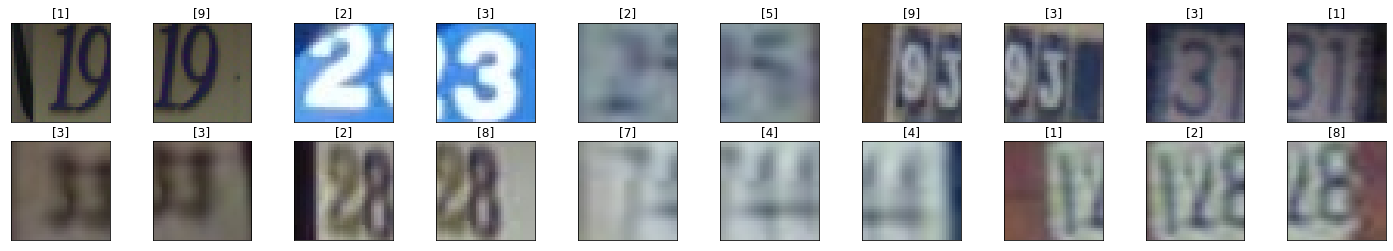

In [4]:
fig = plt.figure(figsize=(25, 4))

for idx in range(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(train['X'][:, :, :, idx])
    ax.set_title(train['y'][idx])

plt.show()

In [5]:
with open('./annotations/person_keypoints_train2017.json', 'r') as _file:
    train_key_points = json.load(_file)

In [6]:
annotations = train_key_points['annotations']
annotations[0].keys()

dict_keys(['segmentation', 'num_keypoints', 'area', 'iscrowd', 'keypoints', 'image_id', 'bbox', 'category_id', 'id'])

In [8]:
print(train_key_points['categories'][0]['keypoints'])

['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']


In [64]:
first_image_info = annotations[0]
print(f'Image id is {first_image_info["image_id"]}')
target_image = '{}.jpg'.format(str(first_image_info["image_id"]).rjust(12, '0'))
print(f'Target image is {target_image}')

Image id is 537548
Target image is 000000537548.jpg


In [57]:
def draw_bbox(img: JpegImagePlugin.JpegImageFile, points: Tuple[float, float, float, float]) -> ImageDraw.Draw:
    """Draws bbox on the image"""
    x_coord, y_coord, width, height = points
    img = img.convert('RGBA')
    overlay = Image.new('RGBA', img.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(overlay)
    draw.rectangle((
        (x_coord, y_coord), 
        (x_coord + width, y_coord + height)), 
        fill=(128,255,255,90), 
        outline=(210,255,255,120),
        width=3
    )
    return Image.alpha_composite(img, overlay)

In [99]:
def crop_bbox(img: JpegImagePlugin.JpegImageFile, points: Tuple[float, float, float, float]) -> ImageDraw.Draw:
    return img.crop((points[0], points[1], points[0] + points[2], points[1] + points[3]))

In [32]:
def get_image_name(image_id: int) -> str:
    return '{}.jpg'.format(str(image_id).rjust(12, '0'))

In [159]:
FONT = ImageFont.truetype('/usr/share/fonts/truetype/freefont/FreeSerif.ttf', 12)
def draw_key_points(img: Image.Image, key_points: List[Tuple[str, List]]) -> Image.Image:
    drawing = ImageDraw.Draw(img)
    for point in key_points:
        if point[1][2] != 0:
            # drawing.point(xy=[point[1][0], point[1][1]], fill='blue')
            drawing.ellipse(xy=[point[1][0], point[1][1], point[1][0] + 3, point[1][1] + 3], fill='blue')
            drawing.text((point[1][0], point[1][1]), text=point[0], font=FONT)
    return img

In [119]:
def group_by_n_elements(iterable: List, number_of_elements: int) -> List:
    return [iterable[x: x + number_of_elements] for x in range(0, len(iterable), number_of_elements)]

In [124]:
def group_with_body_parts(coordinates: List) -> List:
    body_parts = ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']
    grouped = group_by_n_elements(iterable=coordinates, number_of_elements=3)
    result = itertools.zip_longest(body_parts, grouped)
    return list(result)

### Testing on one image

<class 'PIL.JpegImagePlugin.JpegImageFile'>


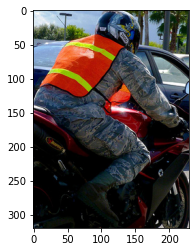

In [97]:
target_bbox = first_image_info['bbox']
with Image.open(f'./train2017/{target_image}') as im:
    # image_with_bbox = draw_bbox(img=im, points=target_bbox)
    cropped_image = crop_bbox(img=im, points=target_bbox)
    plt.imshow(cropped_image)    
    plt.show()


### Cropping images

<class 'itertools.zip_longest'>
<class 'itertools.zip_longest'>
<class 'itertools.zip_longest'>
<class 'itertools.zip_longest'>
<class 'itertools.zip_longest'>
<class 'itertools.zip_longest'>


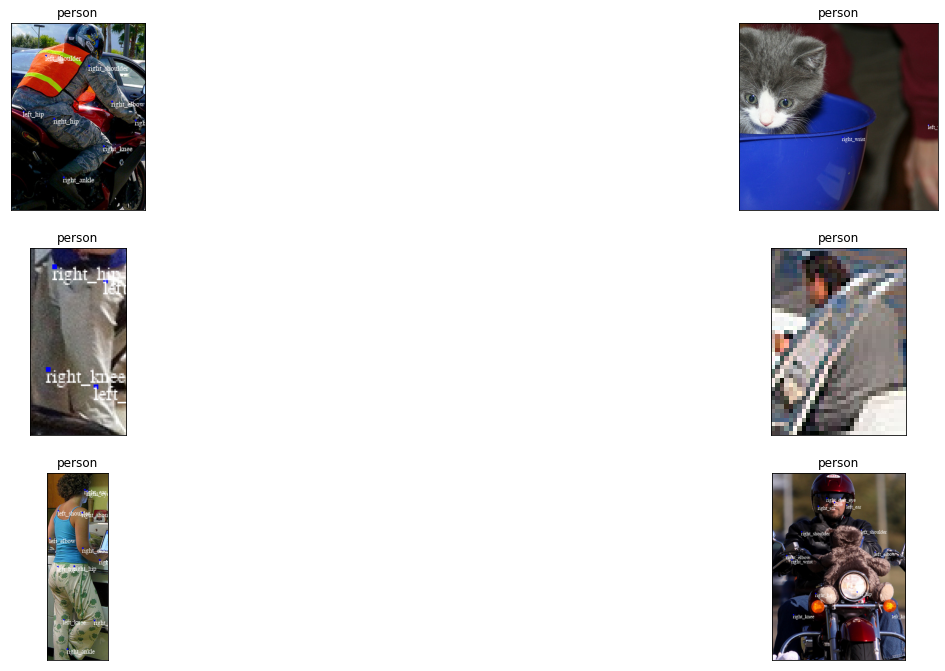

In [168]:
fig = plt.figure(figsize=(25, 20))

cropped_images = []

for idx in range(6):
    ax = fig.add_subplot(5, 2, idx + 1, xticks=[], yticks=[])
    target_image = get_image_name(image_id=annotations[idx]['image_id'])
    with Image.open(f'./train2017/{target_image}') as im:
        # image_with_bbox = draw_bbox(img=im, points=annotations[idx]['bbox'])
        image_with_points = draw_key_points(img=im, key_points=group_with_body_parts(annotations[idx]['keypoints']))
        cropped_image = crop_bbox(img=image_with_points, points=annotations[idx]['bbox'])
        cropped_images.append(cropped_image)
        plt.imshow(cropped_image)
        ax.set_title('person')
plt.show()
    

### Resizing images

ValueError: Unknown resampling filter (192). Use Image.NEAREST (0), Image.LANCZOS (1), Image.BILINEAR (2), Image.BICUBIC (3), Image.BOX (4) or Image.HAMMING (5)

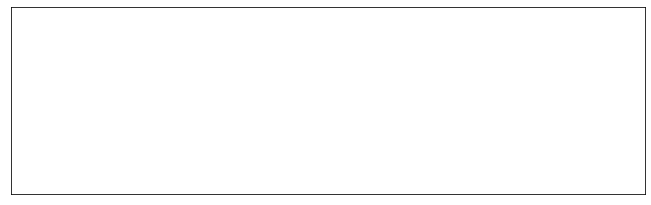

In [169]:
fig = plt.figure(figsize=(25, 20))

for idx, image in enumerate(cropped_images):
    ax = fig.add_subplot(5, 2, idx + 1, xticks=[], yticks=[])
    plt.imshow(image.resize(256, 192))
    ax.set_title('person')
plt.show()
